Time Series Analysis for Dynamical Systems


# 1. Problem Definition: Short Term Load Forecasting

Load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures.


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [16]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.47 s (started: 2024-09-13 13:00:24 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [17]:
#Local Installations
!pip install statsmodels

time: 1.45 s (started: 2024-09-13 13:00:25 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


In [19]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


In [20]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2024-09-13 13:00:27 +02:00)


# 3. Pre-processing


In [23]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:00:46 +02:00)


In [24]:
data = read_Data()

time: 32 ms (started: 2024-09-13 13:00:47 +02:00)


In [25]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 171 ms (started: 2024-09-13 13:00:50 +02:00)


# SARIMAX - Recursive Multi-step Forecasting

 In this approach, a single model is trained to make one-step-ahead predictions, and its outputs are fed back as inputs to forecast multiple steps into the future. For example, if you want to predict three future time steps, you would use the same model to predict the first step, then use that prediction as input to predict the second step, and so on. This method can be computationally efficient but may accumulate errors from each prediction.

### Implementing the Model


In [26]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
# trainin data: filtered copy
train = data.copy()[(data.index >= train_start_dt)& (data.index < test_start_dt)][['load']]
# test data: filtered copy
test = data.copy()[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (18984, 1)
Test data shape:  (72, 1)
time: 0 ns (started: 2024-09-13 13:00:53 +02:00)


In [23]:
#Rescaling the data [0,1]
scaler = pp.MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [24]:
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
order = (3, 1, 6)
#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.
seasonal_order = (1, 1, 1, 24) # 24 is the daily seasonality order

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [25]:
#Model implementation
#here endog is the observed time-series process y:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)

time: 16 ms (started: 2024-09-13 12:15:48 +02:00)


c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [26]:
#Copying the test DF:
test_shifted = test.copy()
#preparing the shifted test data:
for t in range(1, horizon):
  test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
test_shifted = test_shifted.dropna()
test_shifted

,load,load+1,load+2,load+3,load+4,load+5
2014-11-01 00:00:00,0.223112,0.164869,0.140216,0.126656,0.124191,0.135593
2014-11-01 01:00:00,0.164869,0.140216,0.126656,0.124191,0.135593,0.166718
2014-11-01 02:00:00,0.140216,0.126656,0.124191,0.135593,0.166718,0.226502
2014-11-01 03:00:00,0.126656,0.124191,0.135593,0.166718,0.226502,0.305393
2014-11-01 04:00:00,0.124191,0.135593,0.166718,0.226502,0.305393,0.372881
...,...,...,...,...,...,...
2014-11-03 14:00:00,0.430817,0.427427,0.448382,0.502311,0.585824,0.575655
2014-11-03 15:00:00,0.427427,0.448382,0.502311,0.585824,0.575655,0.539599
2014-11-03 16:00:00,0.448382,0.502311,0.585824,0.575655,0.539599,0.490601
2014-11-03 17:00:00,0.502311,0.585824,0.575655,0.539599,0.490601,0.396302


time: 16 ms (started: 2024-09-13 12:15:48 +02:00)


In [27]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2024-09-13 12:15:48 +02:00)


In [28]:
# Predictions on test data:
training_window = 720 # Here we are using a very small portion of the past,
# I think we made like this so that the trining is not too computationaly expensive
train_ts = train['load']
test_ts = test_shifted
#Creating the history
history = [x for x in train_ts]
#Filtering the training window: Uncomment the below line if you want.
history = history[(-training_window):]
#Creating predictions to store the model outcomes:
predictions = list()
#Calling model: 
#Horizon calculation list:
for t in range(0,test_ts.shape[0],horizon):
  model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
  #Model fitting:
  model_fit = model.fit()
  #Model predictions:
  y_p = model_fit.forecast(steps = horizon) # its like model predict in scikit learn
  obs = list(test_ts.iloc[t])
# moving the training window: here I add the prediction as in real life we would 
# not know the true value! Here we will also save the predictions.
  for j in range(horizon):
    predictions.append(y_p[j])
    history.append(y_p[j])
  #Dropping the first horizon elements:
  for j in range(horizon):
    history.pop(0)
  print(test_ts.index[t])
  print(t+1, ': predicted =', y_p, 'true value =', obs)

2014-11-01 00:00:00
1 : predicted = [0.20396937 0.1586907  0.1224784  0.1007945  0.10024499 0.12661711] true value = [0.22311248073959933, 0.16486902927580893, 0.1402157164869029, 0.12665639445300458, 0.12419106317411399, 0.13559322033898302]
2014-11-01 06:00:00
7 : predicted = [0.20381291 0.33660985 0.40871839 0.42752047 0.43690674 0.43673583] true value = [0.1667180277349769, 0.22650231124807396, 0.30539291217257314, 0.3728813559322034, 0.42434514637904464, 0.4489984591679508]
2014-11-01 12:00:00
13 : predicted = [0.42948558 0.41697011 0.40994855 0.39586381 0.39448041 0.41258219] true value = [0.4576271186440677, 0.4499229583975346, 0.44006163328197223, 0.4345146379044684, 0.43852080123266557, 0.4656394453004622]
2014-11-01 18:00:00
19 : predicted = [0.44892143 0.48024573 0.45635781 0.41895429 0.34988961 0.26254473] true value = [0.5044684129429893, 0.5109399075500771, 0.46995377503852076, 0.43050847457627106, 0.3679506933744222, 0.2933744221879815]
2014-11-02 00:00:00
25 : predicted

In [29]:
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
#Updating the indices:
eval_df=(eval_df.set_index(test.index)) #
#Adding true values:
eval_df['actual'] = test['load']
#Let's check:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-11-01 00:00:00 to 2014-11-03 23:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 16 ms (started: 2024-09-13 12:27:17 +02:00)


In [30]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

time: 0 ns (started: 2024-09-13 12:27:17 +02:00)


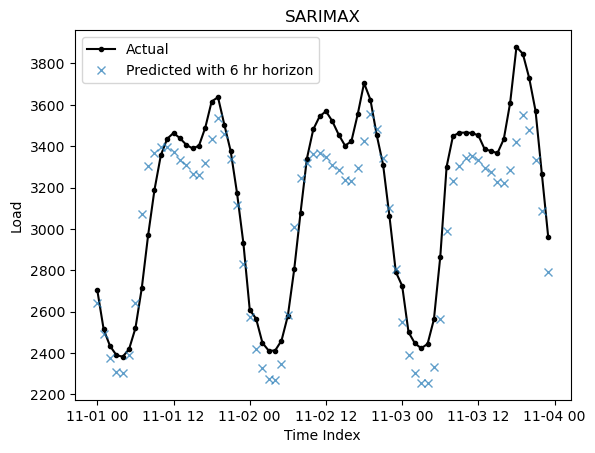

time: 219 ms (started: 2024-09-13 12:27:17 +02:00)


In [31]:
#Plotting predictions: 
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['prediction'], 'x', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[69:138], 'o', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[-69:], '+', alpha=0.70);
plt.legend(['Actual',
            ('Predicted with ' + str (horizon) + ' hr horizon')])
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SARIMAX');


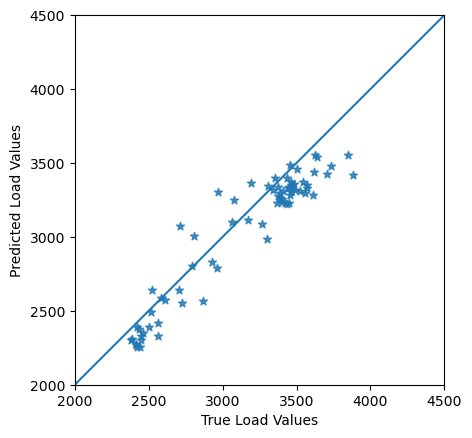

time: 94 ms (started: 2024-09-13 12:27:17 +02:00)


In [32]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['prediction'],marker='*',alpha=0.80)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[69:138],marker='o',alpha=0.60)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[138:207],marker='+',alpha=0.50)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [2000, 4500]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

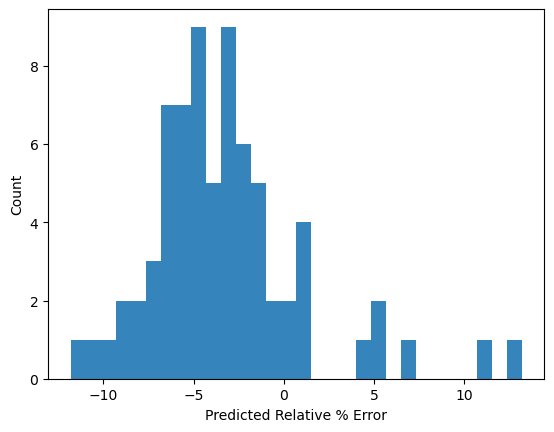

time: 125 ms (started: 2024-09-13 12:27:17 +02:00)


In [33]:
# Calculating the error variations:
error_nn1 = (eval_df['prediction'] - eval_df['actual'])/eval_df['actual']*100

plt.hist(error_nn1, bins=30,alpha=0.9)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [34]:
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  0.85
time: 0 ns (started: 2024-09-13 12:27:17 +02:00)


# ML Algorithms for Forecasting: SVM

## Organizing the Feature Matrix

In [25]:
#Checking Data:
data.sample(3)

,load,T
2011-04-21 07:00:00,3111.0,38.33
2008-04-19 21:00:00,3172.0,57.33
2012-03-06 01:00:00,2827.0,16.67


time: 15 ms (started: 2024-09-13 12:14:21 +02:00)


In [26]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Let's use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Calling Rolling:
window = load_data.rolling(window=width)
#Let's save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78885 entries, 2006-01-01 03:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78885 non-null  float64
 1   std     78885 non-null  float64
 2   T       78885 non-null  float64
 3   load    78885 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 31 ms (started: 2024-09-13 12:14:30 +02:00)


In [27]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 03:00:00,2919.0,117.88271,21.33,2758.0


time: 0 ns (started: 2024-09-13 12:14:33 +02:00)


## Building the X Matrix and Labels

Adding the temporal data with sliding intervals in time. Lets first look with an illustration:

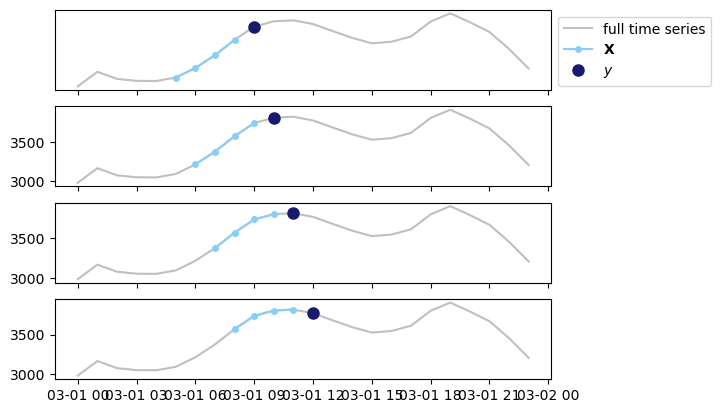

time: 594 ms (started: 2024-09-13 12:14:35 +02:00)


In [28]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create our feature matrix A in this way.

In [201]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 4
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 938 ms (started: 2024-09-13 11:08:25 +02:00)


#### Example:

   The purpose of this loop is to create sliding windows of data for the features (dataX) and the target variable (dataY).

    Let's say our new_dataframe looks like this (a simple example with 7 rows and 4 columns, including the target variable 'load'):

new_dataframe:
|    Date    | median_t | std_t | T_t | load |
|------------|----------|-------|-----|------|
| 2012-09-01 |        1 |     5 |   9 |   13 |
| 2012-09-02 |        2 |     6 |  10 |   14 |
| 2012-09-03 |        3 |     7 |  11 |   15 |
| 2012-09-04 |        4 |     8 |  12 |   16 |
| 2012-09-05 |        5 |     9 |  13 |   17 |
| 2012-09-06 |        6 |    10 |  14 |   18 |
| 2012-09-07 |        7 |    11 |  15 |   19 |

    And we set window = 3.

    Now, let's walk through the loop:

    i = start (i.e., the index of the first row)

    We create a window of size 3 for features:

    1  5  9
    2  6 10
    3  7 11
    We ravel this window into a single row:

    1  5  9  2  6 10  3  7 11
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 16) and add it to dataY.

    i = start + 1 (i.e., the index of the second row)

    We create a window of size 3 for features:

    2  6 10
    3  7 11
    4  8 12
    We ravel this window into a single row:

    2  6 10  3  7 11  4  8 12
    We add this row to dataX.

    For the target variable, we take the 'load' value at the position i + window (i.e., 17) and add it to dataY.

    The loop continues until i = end - window. After the loop, dataX and dataY will look like this:

dataX:
|    Date    | median_t_1 | std_t_1 | T_t_1 | median_t_2 | std_t_2 | T_t_2 | median_t_3 | std_t_3 | T_t_3 |
|------------|------------|---------|-------|------------|---------|-------|------------|---------|-------|
| 2012-09-04 |          1 |       5 |     9 |          2 |       6 |    10 |          3 |       7 |    11 |
| 2012-09-05 |          2 |       6 |    10 |          3 |       7 |    11 |          4 |       8 |    12 |

dataY:
|    Date    | load |
|------------|------|
| 2012-09-04 |   16 |
| 2012-09-05 |   17 |

    In this example, we have created a dataset with sliding windows of size 3, where each row in dataX contains the features from a window and the corresponding row in dataY contains the target variable ('load') right after that window.

    Increasing the value of the sliding window changes the amount of historical data being considered for each instance in the dataset. A larger sliding window size means that more past data points are being used to predict the target variable.

    In the context of your example, increasing the sliding window size to 48 would mean that each instance in dataX would have information from the 48 previous time steps. The physical meaning of this change depends on the temporal resolution of your data. For example, if your data is hourly, a sliding window of 48 would consider the past 48 hours of data for each prediction, while if the data is daily, it would consider the past 48 days.

    A larger sliding window size may capture longer-term patterns in the data, making it potentially more useful for predicting the target variable. However, it's important to note that increasing the sliding window size also increases the dimensionality of the input features, which can lead to a more complex model and may require more computational resources. Additionally, a larger window size may result in less training instances, as more data is required to form each instance.

    Ultimately, the optimal sliding window size depends on the specific problem and the nature of the data. It may be useful to experiment with different window sizes and evaluate the performance of the resulting models to find the best trade-off between capturing meaningful patterns in the data and maintaining a manageable input feature size.

In [202]:
#Original DF:
new_dataframe.loc['2014-09-01 00:00:00':'2014-09-04 00:00:00'].head(6)

,median,std,T,load
2014-09-01 00:00:00,3504.0,339.155815,69.67,3087.0
2014-09-01 01:00:00,3226.0,329.974115,71.00,2886.0
2014-09-01 02:00:00,2986.5,261.282095,70.00,2768.0
2014-09-01 03:00:00,2827.0,169.892123,69.33,2699.0
2014-09-01 04:00:00,2733.5,92.903175,68.33,2681.0
2014-09-01 05:00:00,2694.5,39.686270,68.33,2690.0


time: 16 ms (started: 2024-09-13 11:10:09 +02:00)


In [203]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
2012-09-01 04:00:00,3543.0,524.914199,59.33,2719.0,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0
2012-09-01 05:00:00,3104.5,465.842964,69.67,2817.0,2768.0,335.357521,67.33,2664.0,2691.5,99.408249,69.33,2580.0,2622.0,123.494939,67.67,2537.0


time: 16 ms (started: 2024-09-13 11:10:10 +02:00)


In [204]:
dataX.shape

(19052, 16)

time: 0 ns (started: 2024-09-13 11:10:12 +02:00)


In [205]:
dataY.head(2)

2012-09-01 04:00:00    2537.0
2012-09-01 05:00:00    2525.0
dtype: float64

time: 0 ns (started: 2024-09-13 11:10:12 +02:00)


In [206]:
dataY.shape

(19052,)

time: 0 ns (started: 2024-09-13 11:10:13 +02:00)


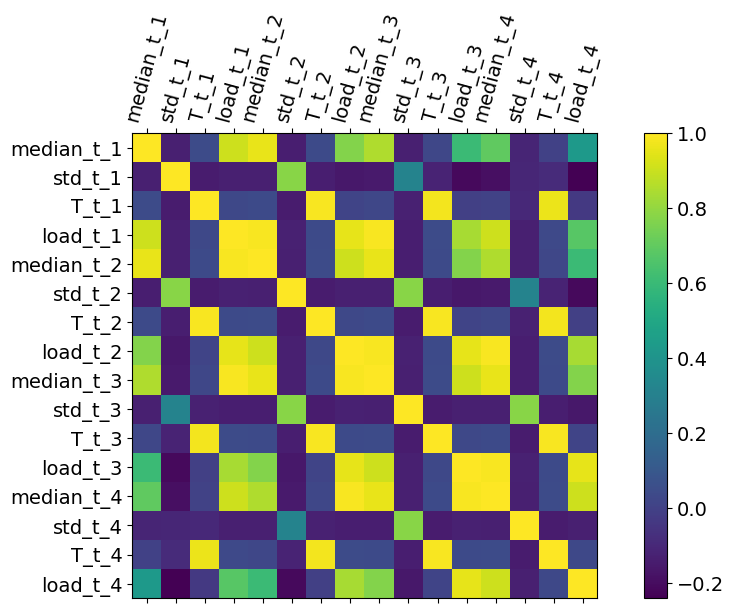

time: 187 ms (started: 2024-09-13 11:10:15 +02:00)


In [207]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [208]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,T_t_3,load_t_3,median_t_4,std_t_4,T_t_4,load_t_4
count,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04,1.905200e+04
mean,2.386875e-16,-7.160624e-17,-3.329690e-15,-2.923921e-16,2.028843e-16,-2.301096e-16,-3.544509e-15,9.845858e-17,-2.237695e-16,-3.136502e-16,-3.520640e-15,-2.028843e-16,-1.670812e-16,-2.465194e-16,-3.580312e-15,4.057687e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.356536e+00,-1.250854e+00,-3.150932e+00,-2.363943e+00,-2.356523e+00,-1.250961e+00,-3.150906e+00,-2.364070e+00,-2.356548e+00,-1.251018e+00,-3.150913e+00,-2.364173e+00,-2.356666e+00,-1.251030e+00,-3.150905e+00,-2.364310e+00
25%,-7.726966e-01,-8.791492e-01,-7.639865e-01,-7.721103e-01,-7.727081e-01,-8.791741e-01,-7.639432e-01,-7.722154e-01,-7.727602e-01,-8.791741e-01,-7.638814e-01,-7.722968e-01,-7.721740e-01,-8.791720e-01,-7.638207e-01,-7.723794e-01
50%,1.141806e-01,-3.143736e-01,9.416024e-02,1.191733e-01,1.141554e-01,-3.142749e-01,9.420957e-02,1.190803e-01,1.140882e-01,-3.141876e-01,9.429610e-02,1.190114e-01,1.140057e-01,-3.141646e-01,9.437566e-02,1.189593e-01
75%,6.730222e-01,7.707527e-01,7.982938e-01,6.788994e-01,6.729884e-01,7.708772e-01,7.983482e-01,6.788141e-01,6.729117e-01,7.710807e-01,7.984550e-01,6.787530e-01,6.728372e-01,7.711371e-01,7.985500e-01,6.787200e-01
max,3.458144e+00,4.153972e+00,2.446595e+00,3.420488e+00,3.458067e+00,4.155047e+00,2.446661e+00,3.420440e+00,3.457943e+00,4.155826e+00,2.446815e+00,3.420417e+00,3.457908e+00,4.156014e+00,2.446946e+00,3.420478e+00


time: 47 ms (started: 2024-09-13 11:10:17 +02:00)


    dataX is a 2-dimensional data structure (a pandas DataFrame) that contains input features for the model. Each row in dataX represents a window of the time series data, containing information like median temperature, standard deviation of temperature, and load for each time step within the window. The columns of dataX are named accordingly (e.g., 'median_t_1', 'std_t_1', 'T_t_1', 'load_t_1').

    dataY is a 1-dimensional data structure (a pandas Series) that contains the target values, which are the load values for the time step immediately following each window in dataX. The purpose of dataY is to provide the true load values that the model should predict based on the input features in dataX.

    Physically, dataX and dataY are in-memory data structures that hold information from the original time series data in a format suitable for training and evaluating a machine learning model. They are constructed using a sliding window approach, extracting relevant features and target values from the time series data to facilitate prediction tasks.

In [211]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Let's use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (18980, 16) (18980,)
Test data shape:  (72, 16) (72,)
time: 16 ms (started: 2024-09-13 11:13:43 +02:00)


## Model Training and Predictions


In [209]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2024-09-13 11:10:26 +02:00)


In [212]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 7.97 s (started: 2024-09-13 11:13:47 +02:00)


In [213]:
#Model Predictions:
#------------------
scoreTraining = model.score(X_train, y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9643835749087705
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9650015835371981
-----------------------------------
time: 4.7 s (started: 2024-09-13 11:14:08 +02:00)


In [214]:
#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 16 ms (started: 2024-09-13 11:14:27 +02:00)


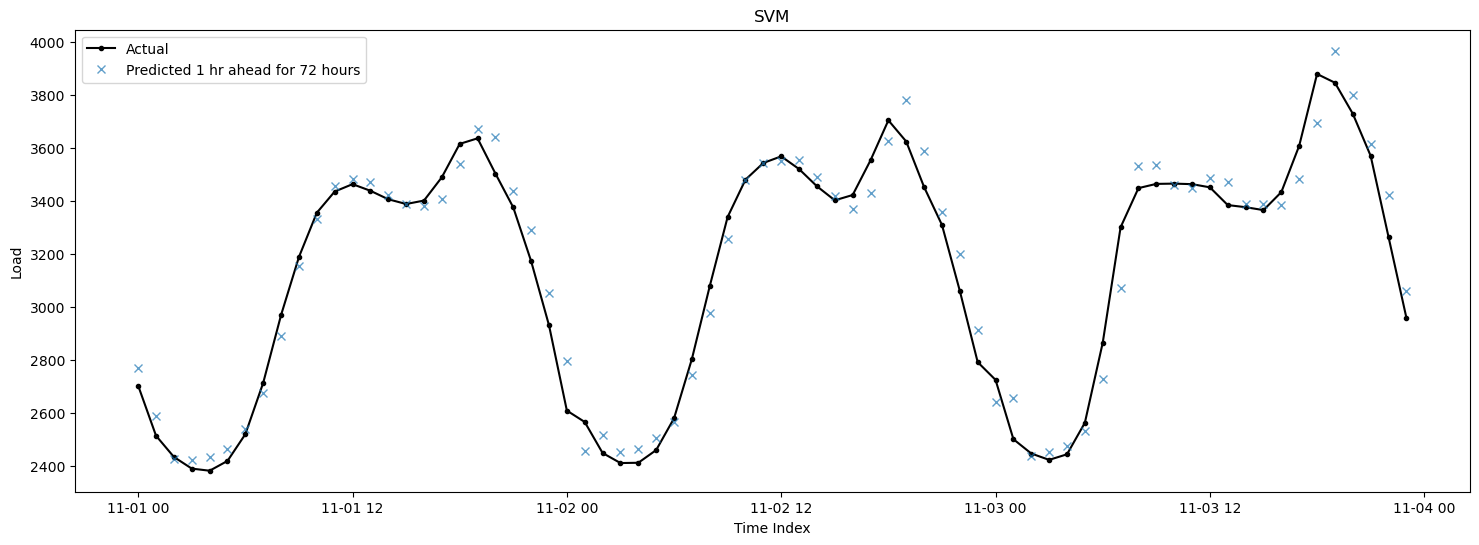

time: 157 ms (started: 2024-09-13 11:14:30 +02:00)


In [215]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

# ML Algorithms for Forecasting: SVM - II 

## Organizing the Feature Matrix

In [216]:
#Checking Data:
data.sample(3)

,load,T,hour,month,dayofWeek
2011-03-25 10:00:00,3556.0,29.67,10,3,25
2006-11-18 01:00:00,2440.0,45.00,1,11,18
2014-09-21 08:00:00,2710.0,61.00,8,9,21


time: 0 ns (started: 2024-09-13 11:14:37 +02:00)


In [217]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 47 ms (started: 2024-09-13 11:14:39 +02:00)


In [218]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-09-13 11:14:44 +02:00)


## Building the X Matrix and Labels

Adding the temporal data with sliding intervals in time. Lets first look with an illustration:

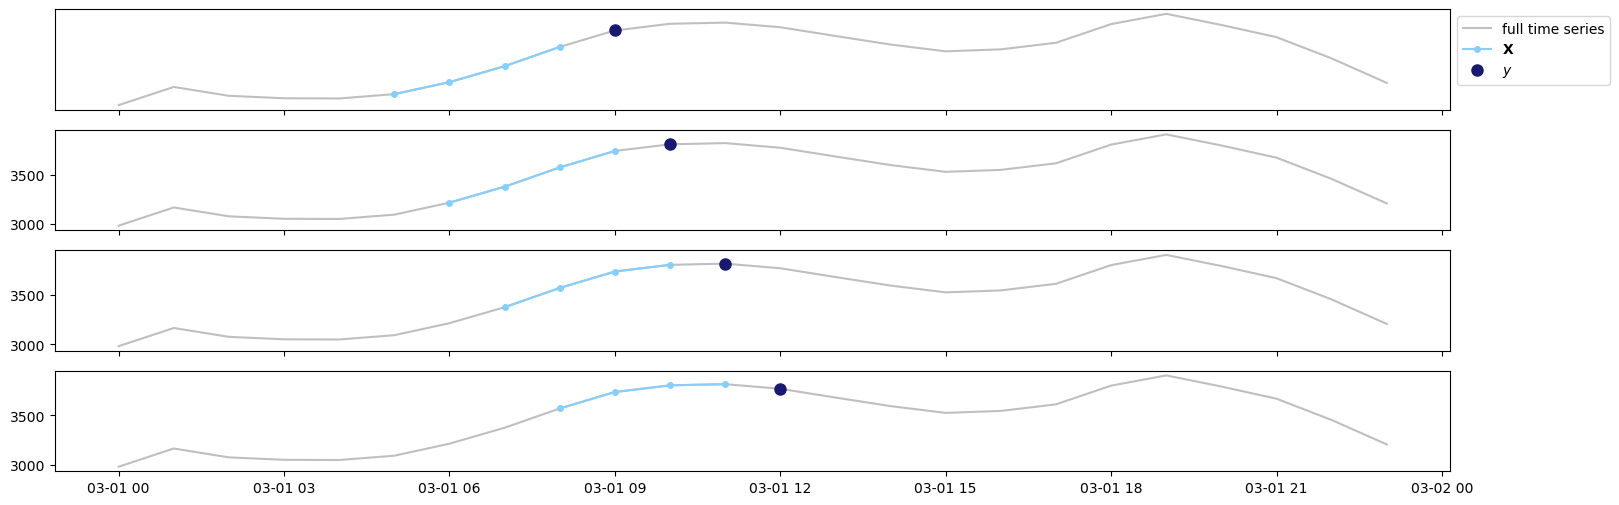

time: 515 ms (started: 2024-09-13 11:14:58 +02:00)


In [219]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));


Lets follow the same logic and create feature matrix A in this way.

In [220]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 953 ms (started: 2024-09-13 11:15:01 +02:00)


In [221]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 0 ns (started: 2024-09-13 11:15:05 +02:00)


In [222]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2024-09-13 11:15:06 +02:00)


In [223]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
dtype: float64

time: 0 ns (started: 2024-09-13 11:15:09 +02:00)


In [91]:
#Correlation Matrix
#correlationMatrix = pd.DataFrame(dataX).corr() 

#f = plt.figure(figsize=(12, 6))
#plt.matshow(correlationMatrix, fignum=f.number)
#plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
#plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.show()

time: 578 µs (started: 2022-12-20 15:08:17 +00:00)


In [224]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,2.613099e-14,-3.181892e-15,1.256010e-16,1.614870e-16,2.555083e-14,-3.576638e-15,-2.392400e-17,-1.256010e-16,2.665731e-14,...,-2.775184e-15,-2.721355e-16,-6.100619e-16,2.441444e-14,-3.050310e-15,-1.824205e-16,6.100619e-16,2.364289e-14,-2.954614e-15,-1.794300e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 329 ms (started: 2024-09-13 11:15:14 +02:00)


In [228]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 47 ms (started: 2024-09-13 11:15:56 +02:00)


## Model Training and Predictions

In [229]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 0 ns (started: 2024-09-13 11:16:03 +02:00)


In [230]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 31 ms (started: 2024-09-13 11:16:05 +02:00)


In [231]:
#Model Predictions:
#------------------
#scoreTraining = model.score(X_train, y_train)
#print('-----------------------------------')
#print('SVM Regression Training R^2 Score: ', scoreTraining)
#print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Validation R^2 Score:  0.923579282187479
-----------------------------------
time: 16 ms (started: 2024-09-13 11:16:08 +02:00)


In [232]:
#Visual Comparisons
#------------------
# Lets get the predictions first:
y_predict = pd.Series(svr.predict(X_test),index=y_test.index)

time: 16 ms (started: 2024-09-13 11:16:17 +02:00)


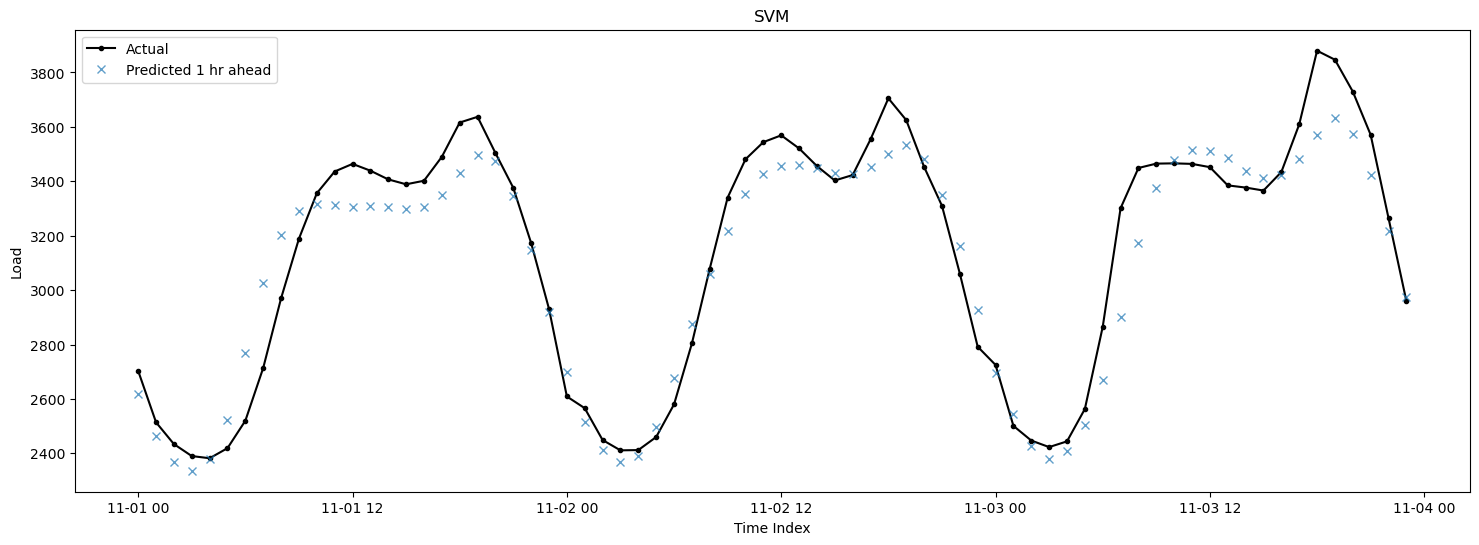

time: 156 ms (started: 2024-09-13 11:16:18 +02:00)


In [233]:
#Plotting the Figure:
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Forecasting further in time...

Lets use the SVM to predict further horizons by just using the training wisdom. Here we will follow a similar anology. We need to update the passed information about the past as we progress. Here, it is a bit more difficult as we need to update the created features as well. Lets see how it can be implemented.


In this section, the goal is to use the Support Vector Machine (SVM) model to make predictions further into the future. This process is called forecasting.

To accomplish this, we need to iteratively update the past information as we progress in time, making predictions for future time steps. This is a more challenging task because we also need to update the features used in the model as we move forward.

The basic idea can be summarized in the following steps:

1. `Train the SVM model on the available historical data.`
2. `Make a prediction for the next time step using the trained model.`
3. `Update the historical data and features with the new prediction.`
4. `Go back to step 2, using the updated historical data and features to make a prediction for the next time step.`

By repeating these steps, we can forecast further into the future while incorporating the information from previous predictions.

The significance of this approach is that it allows us to make predictions beyond the available test data, leveraging the "wisdom" gained from training the model on historical data. This is particularly useful when trying to anticipate trends, make business decisions, or plan for future events based on past patterns.

-----------------------------------------------------------------------------------------------------------------------------
    Here's a simplified, visual example to help you understand how to use an SVM model for forecasting further horizons by updating the input features for each prediction.

    Let's consider a simplified dataset containing only 3 features and the target variable (load) over 5 time steps:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load |
|-----------|-----------|-----------|-----------|------|
| 1         | 1         | 5         | 9         | 13   |
| 2         | 2         | 6         | 10        | 14   |
| 3         | 3         | 7         | 11        | 15   |
| 4         | 4         | 8         | 12        | 16   |
| 5         | 5         | 9         | 13        | 17   |

    We can use a sliding window of size 2 for this example. The dataset would be transformed into the following format:

| Time step | Feature 1_t1 | Feature 2_t1 | Feature 3_t1 | Feature 1_t2 | Feature 2_t2 | Feature 3_t2 | Load |
|-----------|--------------|--------------|--------------|--------------|--------------|--------------|------|
| 3         | 1            | 5            | 9            | 2            | 6            | 10           | 15   |
| 4         | 2            | 6            | 10           | 3            | 7            | 11           | 16   |
| 5         | 3            | 7            | 11           | 4            | 8            | 12           | 17   |

    Now, we train an SVM model using the transformed dataset. To forecast further horizons, we follow these steps:

    1. Train the SVM model on the available historical data.
    2. Make a prediction for the next time step (Time step 6) using the trained model and the last window of features from the historical data (i.e., [3, 7, 11, 4, 8, 12]).
    3. Update the historical data and features with the new prediction. In this case, we would replace the oldest data point (Time step 1) with the new prediction and shift the remaining data points up by one time step. We would also update the features accordingly.
    4. Repeat steps 2-3 to make predictions for further time steps.

    Here's an example of how the historical data and features would be updated after making a prediction for Time step 6:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load    |
|-----------|-----------|-----------|-----------|---------|
| 2         | 2         | 6         | 10        | 14      |
| 3         | 3         | 7         | 11        | 15      |
| 4         | 4         | 8         | 12        | 16      |
| 5         | 5         | 9         | 13        | 17      |
| 6         | New_F1    | New_F2    | New_F3    | New_Load|

    By iteratively updating the historical data and features, we can forecast further into the future, leveraging the "wisdom" gained from training the model on historical data.

In [234]:
#Checking Data:
data.sample(3)

,load,T,hour,month,dayofWeek
2010-04-16 23:00:00,2895.0,38.67,23,4,16
2009-04-25 06:00:00,2254.0,48.00,6,4,25
2009-02-11 15:00:00,3423.0,48.00,15,2,11


time: 0 ns (started: 2024-09-13 11:16:43 +02:00)


In [235]:
#Adding statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 24
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.median(), window.std(),data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std','T', 'load']
new_dataframe = new_dataframe.dropna() 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 31 ms (started: 2024-09-13 11:16:50 +02:00)


In [236]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 16 ms (started: 2024-09-13 11:16:52 +02:00)


In [237]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-12-31 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=new_dataframe.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=new_dataframe.iloc[start+window:end].index)
dataY.column = ['true_load']

time: 1.02 s (started: 2024-09-13 11:16:54 +02:00)


In [238]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 16 ms (started: 2024-09-13 11:16:57 +02:00)


In [239]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2024-09-13 11:16:59 +02:00)


In [240]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
dtype: float64

time: 16 ms (started: 2024-09-13 11:17:06 +02:00)


In [241]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,...,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04,2.037600e+04
mean,1.534348e-16,1.604649e-14,-3.559688e-15,1.115890e-16,-5.551551e-16,1.584563e-14,-3.715913e-15,2.050447e-16,2.901313e-16,1.744136e-14,...,-3.794025e-15,-2.915262e-16,-3.403463e-16,1.468511e-14,-3.626641e-15,-8.648145e-17,6.862721e-16,1.506451e-14,-3.648959e-15,3.849819e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-2.355880e+00,-2.958309e+00,-3.153453e+00,-2.385987e+00,-2.355820e+00,-2.958401e+00,-3.153275e+00,-2.386093e+00,-2.355760e+00,-2.958481e+00,...,-3.147893e+00,-2.387341e+00,-2.357287e+00,-2.959521e+00,-3.147675e+00,-2.387288e+00,-2.357430e+00,-2.959641e+00,-3.147327e+00,-2.387307e+00
25%,-6.224290e-01,-6.242725e-01,-7.685031e-01,-7.777970e-01,-6.223606e-01,-6.242466e-01,-7.683892e-01,-7.778604e-01,-6.222921e-01,-6.242185e-01,...,-7.635315e-01,-7.779760e-01,-6.222434e-01,-6.237019e-01,-7.633885e-01,-7.780103e-01,-6.223742e-01,-6.236980e-01,-7.632052e-01,-7.780655e-01
50%,-1.288194e-01,-9.989587e-02,3.205064e-02,1.232201e-01,-1.287485e-01,-9.984365e-02,3.214288e-02,1.231807e-01,-1.286777e-01,-9.979099e-02,...,3.682467e-02,1.226942e-01,-1.286535e-01,-1.004424e-01,3.694223e-02,1.226109e-01,-1.287808e-01,-1.004188e-01,3.707034e-02,1.225355e-01
75%,6.307080e-01,4.340683e-01,7.981382e-01,6.903942e-01,6.307825e-01,4.339395e-01,7.982098e-01,6.903700e-01,6.308570e-01,4.339409e-01,...,8.027232e-01,6.914441e-01,6.308434e-01,4.343817e-01,8.028165e-01,6.913299e-01,6.307215e-01,4.343356e-01,8.028917e-01,6.912417e-01
max,4.194005e+00,4.584623e+00,2.521444e+00,3.438317e+00,4.194096e+00,4.584911e+00,2.521469e+00,3.438366e+00,4.194188e+00,4.585182e+00,...,2.525603e+00,3.434720e+00,4.192336e+00,4.588446e+00,2.525642e+00,3.434457e+00,4.192239e+00,4.588490e+00,2.525598e+00,3.434307e+00


time: 312 ms (started: 2024-09-13 11:17:07 +02:00)


In [242]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-03 00:00:00    0.658707
2012-09-03 01:00:00    1.198676
2012-09-03 02:00:00    1.076478
2012-09-03 03:00:00    1.180921
2012-09-03 04:00:00    1.094233
                         ...   
2014-12-30 19:00:00   -0.246289
2014-12-30 20:00:00   -0.281278
2014-12-30 21:00:00   -0.385720
2014-12-30 22:00:00   -0.472408
2014-12-30 23:00:00   -0.507396
Name: T_t_1, Length: 20376, dtype: float64

time: 0 ns (started: 2024-09-13 11:17:11 +02:00)


In [243]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 31 ms (started: 2024-09-13 11:17:13 +02:00)


In [244]:
# First element passed to SVM:
X_last = X_test.iloc[0:1]

time: 0 ns (started: 2024-09-13 11:17:15 +02:00)


In [245]:
X_last

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2014-11-01,-0.135467,0.127658,-0.298511,-1.066769,-0.135397,0.121461,0.06713,-1.443769,-0.135326,0.119772,...,-0.206467,0.009662,-0.668777,-0.994718,-0.189113,-0.300789,-0.668908,-0.972099,-0.293376,-0.745773


time: 16 ms (started: 2024-09-13 11:17:16 +02:00)


In [246]:
# Creating a list of last loads:
last_loads = list ()
s_window = 24
for i in range (1,s_window+1):
  column = 'load_t_'+ str (i)
  last_loads.append(X_last[column][0])
last_loads = np.array(last_loads)
last_loads

array([-1.06676868, -1.44376922, -1.59809716, -1.67346251, -1.65371422,
       -1.47603732, -0.99145552, -0.06890565,  0.37799529,  0.38691767,
        0.4066172 ,  0.32041933,  0.24858831,  0.15522374,  0.15340716,
        0.0959495 ,  0.07618368,  0.17128067,  0.44581801,  0.75796848,
        0.66272934,  0.4634543 ,  0.01481442, -0.58630536])

time: 0 ns (started: 2024-09-13 11:17:18 +02:00)


In [247]:
#Creating series for predictions:
y_predicted =pd.Series(index=y_test.index)

time: 0 ns (started: 2024-09-13 11:17:46 +02:00)


In [248]:
#import lib
from pandas.tseries.offsets import DateOffset

time: 0 ns (started: 2024-09-13 11:17:47 +02:00)


In [249]:
#Conversion:
X_test_last = X_last.to_numpy()
X_test_last.shape

(1, 192)

time: 0 ns (started: 2024-09-13 11:17:48 +02:00)


In [250]:
X_test_last

array([[-0.13546731,  0.12765831, -0.29851068, -1.06676868, -0.13539651,
         0.12146142,  0.06713026, -1.44376922, -0.13532571,  0.11977188,
        -0.01999049, -1.59809716, -0.13525491,  0.11427877, -0.12435371,
        -1.67346251, -0.13518411,  0.10609373, -0.1937283 , -1.65371422,
        -0.13511331,  0.09645576, -0.24587036, -1.47603732, -0.13504251,
         0.08734555, -0.31525035, -0.99145552, -0.13497171,  0.08990252,
        -0.33292245, -0.06890565, -0.09833772,  0.10109127, -0.40229381,
         0.37799529, -0.09827176,  0.10370958, -0.38497225,  0.38691767,
        -0.09821017,  0.10160344, -0.21044671,  0.4066172 , -0.13308568,
         0.07341006, -0.05367567,  0.32041933, -0.18792095,  0.04455861,
         0.15533126,  0.24858831, -0.20120424,  0.01180959,  0.24213534,
         0.15522374, -0.29925239, -0.02198351,  0.32947277,  0.15340716,
        -0.38734412, -0.04560535,  0.32959266,  0.0959495 , -0.44220897,
        -0.07167113,  0.38195809,  0.07618368, -0.4

time: 0 ns (started: 2024-09-13 11:17:50 +02:00)


In [251]:
#Going into loop: we will loop over the y_test indices and update X_test_last at each loop:
case_indices = y_test.index
#n_features:
n_features = 4
#For scaling the predictions:
dummy_array = np.zeros((1,X_test_last.shape[1]))
for case_index in case_indices:
  #Predicting with fitted SVM and writing the result on y_predicted at the same time:
  load_prediction = svr.predict(X_test_last).flatten()[0]
  #print(load_prediction)
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  #Preparing the next X_test_last:
  #
  # We need to scale the load first:
  dummy_array[0,X_test_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,X_test_last.shape[1]-1]
  #
  #---updating load list---:
  last_loads = np.delete(last_loads,0)
  last_loads = np.append(last_loads,load_scaled)
  #print(last_loads)
  #
  #---finding new values:
  median_i = np.median(last_loads)
  std_i = np.std(last_loads)
  min_i = np.min(last_loads)
  max_i = np.max(last_loads)
  #here I assume that T data is available from weatherforecasting etc.
  time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
  temp_i= temp_test.loc[time_index] #already scaled!
  #
  #updating X_last:
  for i in range (X_test_last.shape[1]-n_features):
    X_test_last[0][i] =X_test_last[0][i+n_features]

  X_test_last[0][X_test_last.shape[1]-n_features+0] =median_i
  X_test_last[0][X_test_last.shape[1]-n_features+1] =std_i
#  X_test_last[0][X_test_last.shape[1]-n_features+2] =min_i
#  X_test_last[0][X_test_last.shape[1]-n_features+3] =max_i
  X_test_last[0][X_test_last.shape[1]-n_features+2] =temp_i
  X_test_last[0][X_test_last.shape[1]-n_features+3] =load_scaled


time: 79 ms (started: 2024-09-13 11:17:52 +02:00)


c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have vali

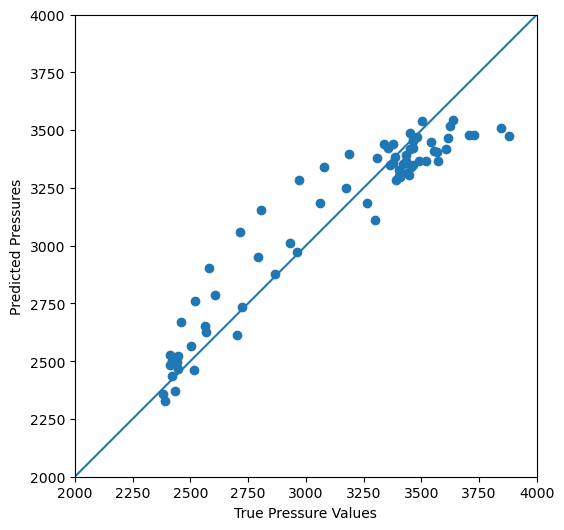

time: 94 ms (started: 2024-09-13 11:18:10 +02:00)


In [252]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predicted)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

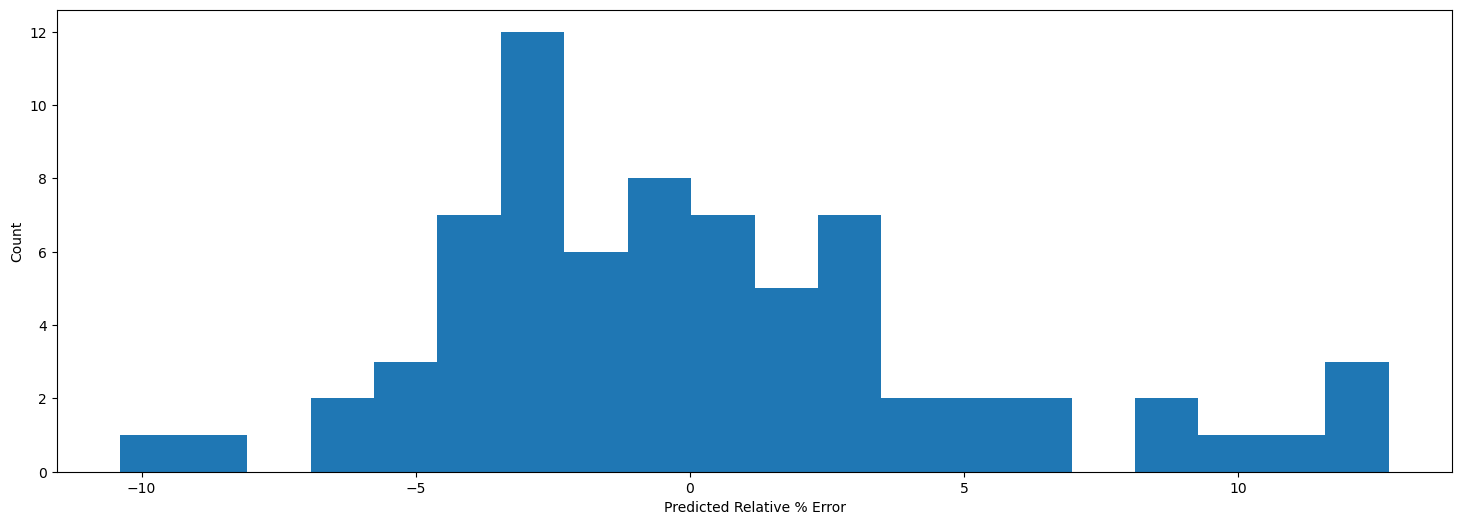

time: 125 ms (started: 2024-09-13 11:18:12 +02:00)


In [253]:
# Calculating the error variations:
error_nn = (y_predicted - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [254]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test)/y_test*100
np.average(error_nn)

0.20082137383592272

time: 0 ns (started: 2024-09-13 11:18:15 +02:00)


In [255]:
#Calculating R2 value:
r2_test = r2_score(y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89
time: 0 ns (started: 2024-09-13 11:18:16 +02:00)


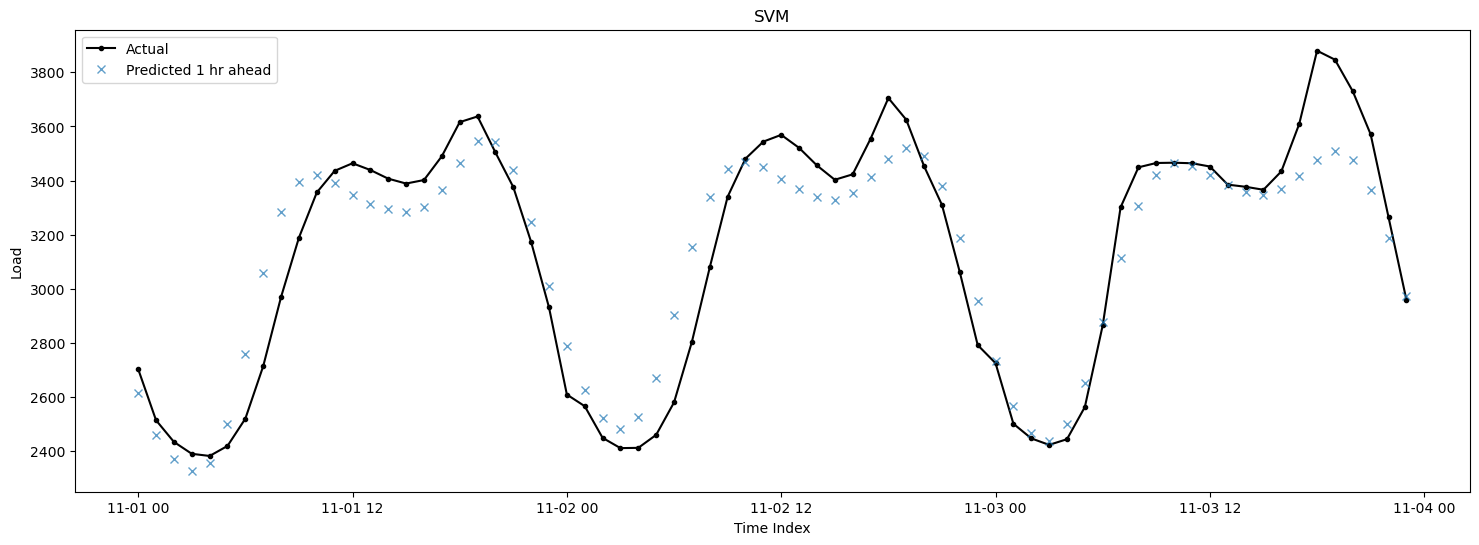

time: 156 ms (started: 2024-09-13 11:18:19 +02:00)


In [256]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]